<a href="https://colab.research.google.com/github/matteobisardi/ALGOSB_2021_tutorial/blob/main/src/arDCA_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  General aim of the tutorial
**What we would like to show you**

How to learn a simple generative model, called autoregressive. This notebook is using a small family, PF00014, but you can use another family if you prefer. If you want to do some tests with families that are long and have a large number of sequences, you shoul consider using the julia implementation.

**What you could do with what you learn**

 - Generation of artificial sequences
 - Some statistical tests to see if your sequences are similar to the natural sequences
 

The code presented here is a Python implementation of much faster Julia code. This means that the models you will learn today in the short time of the presentation are not state-of-the-art but simple Julia packages are available at [ArDCA](https://github.com/pagnani/ArDCA.jl).

**Plan of the tutorial**

You can read it off the *Table of Contents* on the left

# Read alignment and compute frequencies #

Here we import a **Multiple Sequence Alignment (MSA)**, we compute the weigts of the sequences and explore a bit the dataset. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [ ]:
 #@title Useful code
def letter2number(a): 
    #to convert the amino acids letters into integer numbers from 0 to 20
    switcher = {
        '-': 20,
        'A': 0,
        'C': 1,
        'D':2,
        'E':3,
        'F':4,
        'G':5,
        'H':6,
        'I':7,
        'K':8,
        'L':9,
        'M':10,
        'N':11,
        'P':12,
        'Q':13,
        'R':14,
        'S':15,
        'T':16,
        'V':17,
        'W':18,
        'Y':19,     
    }
    return switcher.get(a,20)


# read MSA and convert it to matrix
def fasta2matrix(path):
    data=open(path, 'r')
    seqs_temp = data.readlines()
    data.close()

    if seqs_temp[2][0] != '>':
        seqs_temp = [seqs_temp[i][:-1] for i in range(int(len(seqs_temp)))]
        seqs = [ "".join(  seqs_temp[ 4*i +1  :  4*i +4 ]  )  for i in range(int(len(seqs_temp)/4))]
    else:
        seqs = [seqs_temp[2*i+1][:-1] for i in range(int(len(seqs_temp)/2))]
    
    M = np.size(seqs)
    L = len(seqs[0])
    print(f"M = {M}, L = {L} \n")
    align=np.zeros((M,L)).astype(int)
    for m in range(M):
        for i in range (L):
            align[m,i]=letter2number(seqs[m][i])
    return align

def onehot(MSA):
    M, L = MSA.shape
    q = 21        
    msa = np.zeros( (M,L*q) )
    for m in range (M):
        for i in range (L):
            msa[m, i*q+MSA[m,i]]=1 
    return msa

# compute weights
def compute_weights(MSA, θ = 0.8):
  msa_compute_weights = np.eye(21)[MSA.astype(int)]
  mat_dist = np.tensordot(msa_compute_weights,msa_compute_weights,[[1,2],[1,2]])/msa_compute_weights.shape[1]
  trainingWeights = 1/np.sum(mat_dist>=θ,axis = 1)
  return trainingWeights

def numbertoletter(n):
    switcher = {
        20:'-',0:'A',1:'C',
        2:'D',3:'E',4:'F',
        5:'G',6:'H',7:'I',
        8:'K',9:'L',10:'M',
        11:'N',12:'P',13:'Q',
        14:'R',15:'S',16:'T',
        17:'V',18:'W',19:'Y',     
    }
    return switcher.get(n,20)
def write_sequence(sequence):
  st = [numbertoletter(i) for i in sequence]
  print(''.join(st))
  return''.join(st)


In [ ]:
%%bash
wget -qnc https://raw.githubusercontent.com/matteobisardi/ALGOSB_2021_tutorial/main/data/PF00014_mgap6.fasta

In [ ]:
# Open the file and write in "seqs" a list containing all lines
align = fasta2matrix('PF00014_mgap6.fasta')

# compute the weights
trainingWeights = compute_weights(align)

# one hot encoding
msa = onehot(align)
M, L = np.shape(align)
q = 21

M = 13600, L = 53 



In [ ]:
#Calculate the 1-point frequencies 
msa_reweighted = np.copy(msa[:M,:])

for i in range(len(msa[:M,1])):
    msa_reweighted[i,:]*= trainingWeights[i]/np.sum(trainingWeights)
p=np.sum(msa_reweighted,0)


In [ ]:
#Pseudocount alfa
alfa=0.0001;
pa=(1-alfa)*p+alfa/21.

## Resample sequences
In order to have a smaller dataset of independent sequences, we are going to resample them with respect to their weight.

In [ ]:
li_resample = (np.random.random(M)-trainingWeights)<0
msa_resample = msa[li_resample,:]

# Keras

We want to learn an autoregressive model which is a generative model.

The probability of a sequence $ (s_1, s_2,...,s_L)$ is given by :

$p(s_1, s_2,...,s_L) = p(s_1) p(s_2 | s_1) ... p(s_L | s_{L-1},...,s_1)$ by Bayes decomposition.

Then each conditional probability is written in a "Potts" like form: $p(s_i | s_{i-1},...,s_1) = \frac{\exp(h_i(s_i)+\sum_{j<i} J_{ij}(s_i,s_j))}{Z_{s_{i-1},...,s_1}}$

- Learning

The parameters are learned by maximizing the log-likelihood, i.e maximizing $\frac{1}{M}\sum_{m = 1}^{M} \log{p(s_1^m, s_2^m,...,s_L^m)}$.

Since each parameter appears in only one conditional probability, we can optimize every conditional probability independently : $\frac{1}{M}\sum_{m = 1}^{M} \log{p(s_i^m| s_{i-1}^m,...,s_1^m)}$



- Sampling

    - Sampling from the model is very simple due to the autoregressive property: 
    - Sample the first amino acid $k$ from $p(s_1)$
    - Sample the second from $p(s_2 | k)$
    - Iterate


The learning is done with keras: the input for a given site $i$ (and its conditional probability) is the sequence before the site $i$ in one-hot-encoding, the output is a q-vector corresponding to the probability to emit one of the $q$ amino acids. The learning is done by minimizing the categorigal cross entropy (which is completly equivalent to the maximization of  $\frac{1}{M}\sum_{m = 1}^{M} \log{p(s_i^m| s_{i-1}^m,...,s_1^m)}$ )

In [ ]:
#Mask
def inputrange(i):
    return [j for j in range(L*q) if (j//q != i) and (j//q)<i]
def outputrange(i):
    return [j for j in range(L*q) if j//q == i]

Let's plot the loss and the accuracy for one site.

Text(0, 0.5, 'Loss')

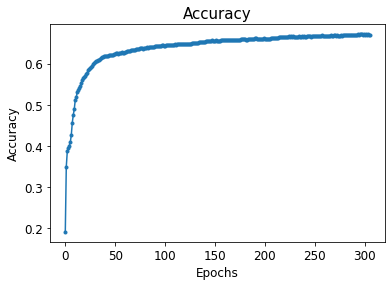

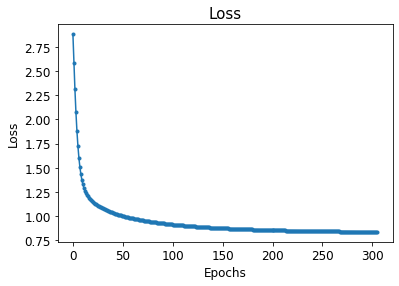

In [ ]:
i = 20
model = Sequential()
model.add(Dense(q, activation="softmax", use_bias = True,
                    input_shape=((i)*q,),
                    kernel_regularizer=l2(0.0001),
                    bias_regularizer = l2(0.00001)))
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
batch_size = int(msa_resample.shape[0]/10)
epochs = 2000
es = EarlyStopping(monitor='loss',min_delta=0.001,verbose=0,patience=10)
history = model.fit(msa_resample[:,inputrange(i)], msa_resample[:,outputrange(i)],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=True,
                    callbacks=[es],
                    #sample_weight=trainingWeights[:]
                   )
plt.plot(history.history['accuracy'],".-")
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title("Accuracy", size = 15)
plt.xlabel("Epochs",size = 12)
plt.ylabel("Accuracy",size = 12)



plt.figure()
plt.plot(history.history['loss'],".-")
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title("Loss", size = 15)
plt.xlabel("Epochs",size = 12)
plt.ylabel("Loss",size = 12)




Here is the learning of the whole model. You can try to change the number of epochs to increase or decrease the quality of the model. With the current number of epochs, the learning takes around 12 mn.

In [ ]:
# -----This will take around 10 minutes to run

#Initialize parameters
h=np.zeros(L*q)
J=np.zeros((L*q,L*q))

#Initialize the sample, and sample the first site from the profile model
nb_sample = 10000
sample = np.zeros((nb_sample,L))
for i in range(nb_sample):
    sample[i,0] =  np.random.choice(np.arange(0,21), 1, p=pa[:q])[0]
sample_one_hot = onehot(sample[:,:1])


print('Learning has started!\n')
for i in range(1,L):#optimization is done for each conditional probability independently 
    if i%10 == 0:
      print(f"site : {i} (out of {L})")
    model = Sequential()
    model.add(Dense(q, activation="softmax", use_bias = True,
                    input_shape=((i)*q,),
                    kernel_regularizer=l2(0.0001),
                    bias_regularizer = l2(0.00001)))
    model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
    batch_size = int(msa_resample.shape[0]/10)
    epochs = 2000
    es = EarlyStopping(monitor='loss',min_delta=0.001,verbose=0,patience=10)
    history = model.fit(msa_resample[:,inputrange(i)], msa_resample[:,outputrange(i)],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=True,
                    callbacks=[es],
                    #sample_weight=trainingWeights[:]
                   )
    prob = model.predict(sample_one_hot)
    
    for k in range(nb_sample):
        sample[k,i] = np.random.choice(np.arange(0,21), 1, p=prob[k,:])[0]
    sample_one_hot = onehot(sample[:,:i+1])
    

    W=np.asarray(model.get_weights()[0])
    Wh = np.asarray(model.get_weights()[1])

    h[i*q:(i+1)*q]=Wh[:]
    
    for j in range(i):
        J[j*q:(j+1)*q,i*q:(i+1)*q]=W[j*q:(j+1)*q,:]
        
print('Done!')      

site :  10
site :  20
site :  30
site :  40
site :  50


Let us print some sequences we generated.


In [ ]:
#write the 10 first sequences of our sample
for k in range(10):
  write_sequence(sample[k,:])

ICSQPPDVGTCRSLKPRWHYDPAAEKCLAFSFSGCGGNLNNFATKEQCERACM
VCQLPLENGPCSANDARYYYDQNAGSCKQFTFGGCQGNKNNFRTLDECMKACA
ICGWHPEPGPCRKTYCRWFYNLTTQYCQPFNYGGCDGNANRFLDETSCQSRCE
-----KVLAECKANFTRWWYDVTNQQCKK-QYGGCQGNPNNFQTQMECQKAC-
-CQSASEAGSCASFLPRWYYNTQTSTCQQFIFGGCAGNDNNFKSQYDCENTC-
VCVKPPDYGNCSETVQAWYFEPSENRCKPFDYSSCGGNDNRFESETACMNYCK
ACSMPPEPGMCRANFQRWYFDQTAGECKSFVYGGCNGNQNNFVTQDMCQSKCK
-CRLPVATNVCRMYIPRWYFDPTEGKCKKFIYGGCQGNENRFETQEECEAKC-
FCYLEPDPGPCLATVTRYAFKHMWQKCVTFQYGGCEGNLNNFPTLEACERYCM
VCRQSPDPGPCRAYVERWAYNPFAGQCASFVYGGCMGNGNNFETKDECAKKC-


In [ ]:
# you can also use this function to sample sequences from your model parameters
def sampling(JJ,hh,freq,nb_sample,L):
    J = np.copy(JJ)
    h = np.copy(hh)
    #we sample the first site from the data frequencies:
    sample = np.zeros((nb_sample,L))    
    sample[:,0] =  np.random.choice(np.arange(0,21), nb_sample, p=freq)

    def conditional_proba(seq,site,J,h,L):
        tab_prob = np.zeros(q)
        tab_prob[:] = h[site*q:(site+1)*q] #fields
        for k in range(q):
            tab_prob[k]+=np.sum(J[[j*q+int(seq[j]) for j in range(site)],site*q+k])#couplings
        #print(tab_prob)
        exptab = np.exp(tab_prob)
        return exptab/np.sum(exptab)
    for i in range(1,L):
        for k in range(nb_sample):
            probs = conditional_proba(sample[k,:],i,J,h,L) 
            sample[k,i] = np.random.choice(np.arange(0,21),1,p = probs)[0] 
    return sample
            
        

In [ ]:
#generate 500 sequences
sample2 = sampling(J,h,pa[:q],500,L)


# 1-point frequencies
We are going to do some simple tests to see if the model is able to reproduce the statistical features of the natural data. We will compare to a simpler model, the profile model that reproduces only the column frequencies of the dataset.

Let us check that the one-point frequencies (column frequencies) $f_i(k)$ are well-reproduced by the model. 

In [ ]:
# create a profile model sample
nb_sample = 10000
sample_pro = np.zeros((nb_sample,L))
site =0
for site in range(L):
    #for i in range(nb_sample):
    sample_pro[:,site] =  np.random.choice(np.arange(0,21), nb_sample, p=pa[site*q:(site+1)*q])

In [ ]:
sample_one_hot_stats = np.eye(21)[(sample).astype(int)]
msa_one_hot_stats = np.eye(21)[align.astype(int)]
sample_pro_one_hot_stats = np.eye(21)[sample_pro.astype(int)]

In [ ]:
def get_stats(X, W=None):
    n = None
    if W is None:
        f_i = np.mean(X,0)
        f_ij = np.tensordot(X,X,[0,0])/X.shape[0]
    else:
        f_i = np.sum(X * W[:,n,n],0)/W.sum()
        Xs = X * np.sqrt(W[:,n,n])
        f_ij = np.tensordot(Xs,Xs,[0,0])/W.sum()
    c_ij = f_ij - f_i[:,:,n,n] * f_i[n,n,:,:]
    return f_i, f_ij, c_ij*(1-np.eye(L)[:,None,:,None])

In [ ]:
stats_sample = get_stats(sample_one_hot_stats)
stats_msa = get_stats(msa_one_hot_stats,trainingWeights)
stats_sample_pro = get_stats(sample_pro_one_hot_stats)

Text(0, 0.5, 'Sample profile')

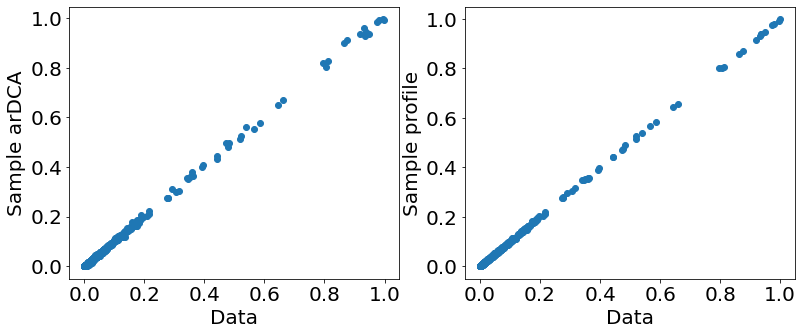

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(121)
plt.scatter(stats_msa[0].flatten(),stats_sample[0].flatten())
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Data",size = 20)
plt.ylabel("Sample arDCA",size = 20)
plt.subplot(122)
plt.scatter(stats_msa[0].flatten(),stats_sample_pro[0].flatten())
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Data",size = 20)
plt.ylabel("Sample profile",size = 20)

The two models are able to reproduce the one-point frequencies.

# 2-point Connected frequencies

The connected correlations are defined by $c_{ij}(k,l) = f_{ij}(k,l) - f_i(k)f_j(l)$

Text(0, 0.5, 'Sample profile')

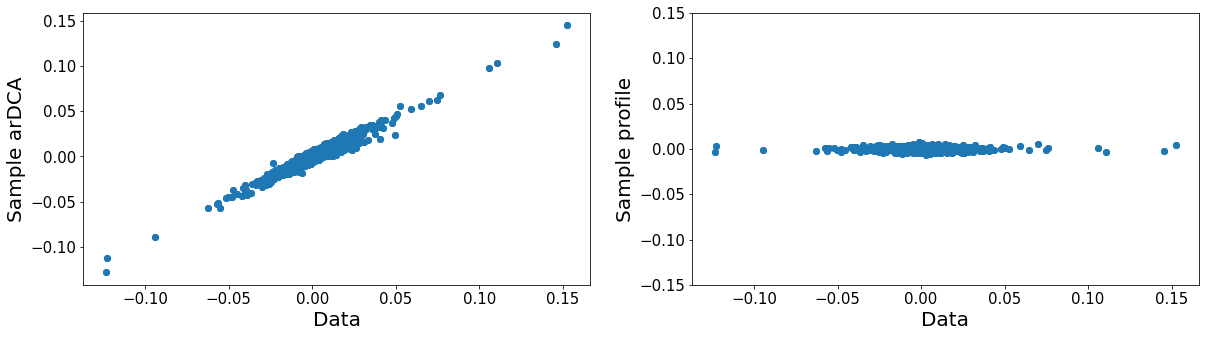

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.scatter(stats_msa[2].flatten(),stats_sample[2].flatten())
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Data",size = 20)
plt.ylabel("Sample arDCA",size = 20)
plt.subplot(122)
plt.scatter(stats_msa[2].flatten(),stats_sample_pro[2].flatten())
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim([-0.15, 0.15])
plt.xlabel("Data",size = 20)
plt.ylabel("Sample profile",size = 20)

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(msa[:M,:])

In [ ]:
X = pca.transform(msa[:M,:])
X2 = pca.transform(sample_one_hot)

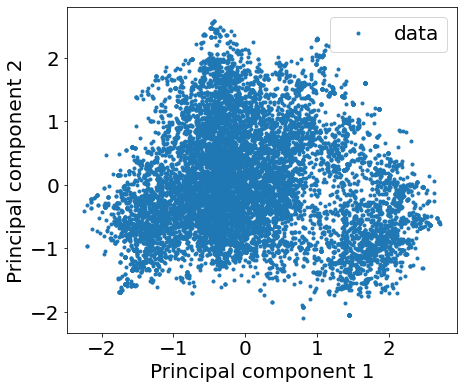

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'.',label = "data")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

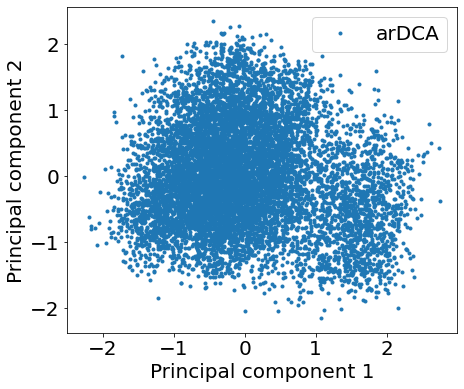

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(X2[:,0],X2[:,1],'.',label = "arDCA")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

Can a profile model reproduce the PCA plot?

In [ ]:
sample_pro_one_hot =np.zeros((nb_sample,L*q))#.astype(int)  
for m in range(nb_sample):
    for i in range(L):
        sample_pro_one_hot[m,i*q+int(sample_pro[m,i])]=1 

In [ ]:
X3 = pca.transform(sample_pro_one_hot)

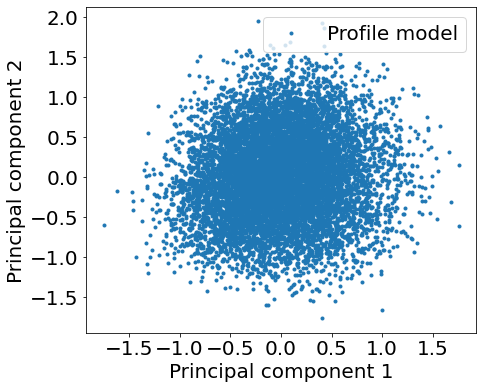

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(X3[:,0],X3[:,1],'.',label = "Profile model")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

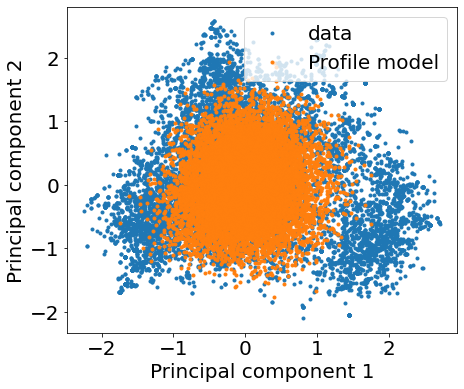

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'.',label = "data")
plt.plot(X3[:,0],X3[:,1],'.',label = "Profile model")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

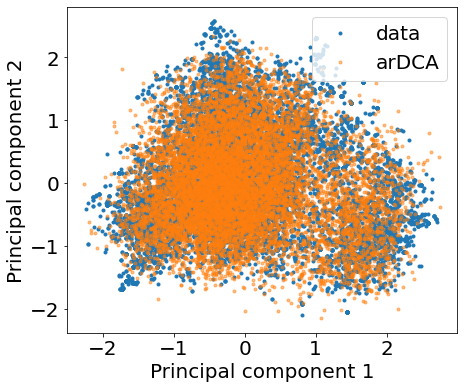

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(X[:,0],X[:,1],'.',label = "data")
plt.plot(X2[:,0],X2[:,1],'.',alpha = 0.5,label = "arDCA")
plt.xlabel("Principal component 1",size = 20)
plt.ylabel("Principal component 2",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)
plt.show()

# Minimum Distance
We want to check that the model is not just learning the MSA and can actually generate sequences that are not too close to the natural sequences. We are going for each sequence of the sample to compute the min Hamming distance to the natural data.

<font color='red'> **Attention**:  </font> Don't run this  cell again to avoid overload of RAM.

In [ ]:
#First concatenate the sample and the data
sample_data = np.concatenate((sample[:1000],align))

#Then compute the matrix of distances
to_compute_min_dist = np.eye(21)[sample_data.astype(int)]
mat_dist_sample_data = 1-np.tensordot(to_compute_min_dist,to_compute_min_dist,[[1,2],[1,2]])/to_compute_min_dist.shape[1]



In [ ]:
#Put big values at positions [i,i] to not take into account the distance between the same sequence
for i in range(1000+align.shape[0]):
  mat_dist_sample_data[i,i] = 100

In [ ]:
#Compute the min distance to the data
min_dist = np.min(mat_dist_sample_data[:1000,1000:]*L,axis = 0)
#Compute the min distance to the sample
min_dist_sample = np.min(mat_dist_sample_data[:1000,:1000]*L,axis = 0)


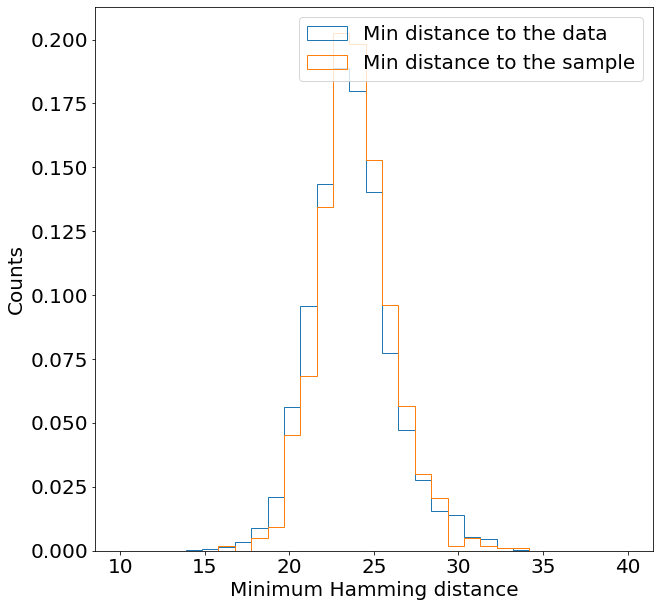

In [ ]:
# Compare the two
plt.figure(figsize = (10,10))
plt.hist(min_dist,histtype = "step",density = True,label = 'Min distance to the data',range = (10,40),bins = 31)
plt.hist(min_dist_sample,histtype = "step",density = True,label = 'Min distance to the sample',range = (10,40),bins = 31)
plt.xlabel("Minimum Hamming distance",size = 20)
plt.ylabel("Counts",size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(fontsize = 20)